In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import multivariate_normal
import random as rn
import iso_forest as iso
import seaborn as sb
import time
sb.set_style(style="whitegrid")
sb.set_color_codes()

/Users/sahand/anaconda/envs/python2/lib/python2.7/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated since IPython 4.0. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


## Create Fake Data

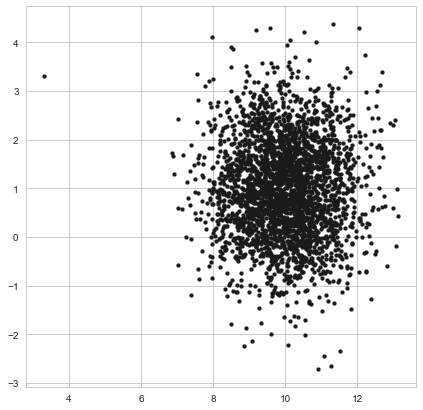

In [2]:
mean = [10, 1]
cov = [[1, 0], [0, 1]]  # diagonal covariance
Nobjs = 3000
x, y = np.random.multivariate_normal(mean, cov, Nobjs).T
#Add manual outlier
x[0]=3.3
y[0]=3.3
X=np.array([x,y]).T
plt.figure(figsize=(7,7))
plt.scatter(x,y,s=15,facecolor='k',edgecolor='k')

# No Parallelization in Training. Parallelize Trees. 

## Create Forest

In [3]:
F = iso.iForest(X,ntrees=500, sample_size=256)

## Sparkify

We distribute the trees in a single forest. We loop through each data point and using spark figure out the anomoly score for a single given datapoint produced by this forest. 

In [5]:
trees = sc.parallelize(F.Trees)
jobsizes = [10,50,100,150,200]
times1 = []
for jobsize in jobsizes:
    x, y = np.random.multivariate_normal(mean, cov, Nobjs).T
    t1 = time.time()
    S1 = np.zeros(len(X))
    for i in  range(len(X)):
        hs1 = trees.map(lambda t: iso.PathFactor(X[i], t).path*1.0)
        h_temp1 = hs1.reduce(lambda a,b: a+b)
        Eh = h_temp1/F.ntrees
        S1[i] = 2.0**(-Eh/F.c)    
    t2 = time.time()
    times1.append(t2-t1)

We distribute the trees ins a single forest. Rather than looping through data points, we compute necessary components of computing the anomoly score in a vectorized way do a single reduce operation to ge the anomoly scores for all data points. 

In [6]:
trees = sc.parallelize(F.Trees)
jobsizes = [10,50,100,150,200]
times2 = []
for jobsize in jobsizes:
    t1 = time.time()
    S_temp = trees.map(lambda t: 2.0**(iso.PathFactor2(X, t).paths*(-1.0)/F.ntrees/F.c))# this is an array (maybe np array) of 2^(-h/(F.ntrees*F.C))
    S = S_temp.reduce(lambda a,b: a*b) # Note that reduce is a multiplication operator
    t2 = time.time()
    times2.append(t2-t1)
print "Time spent: ", (t2-t1)

Time spent:  18.7021110058


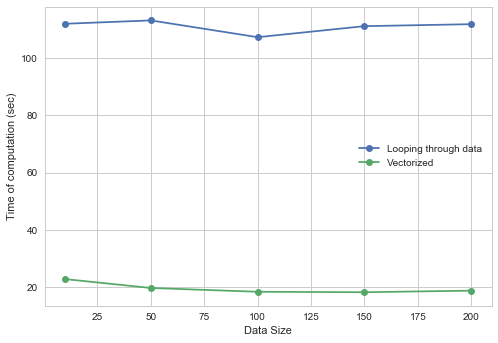

In [22]:
plt.plot(jobsizes,times1,'-ob',label="Looping through data")
plt.plot(jobsizes,times2,'-og',label="Vectorized")
plt.xlabel('Data Size')
plt.ylabel('Time of computation (sec)')
plt.legend()